In [1]:
using LinearAlgebra
using ForwardDiff
using Plots
using Distances
using NNlib
using BenchmarkTools
using Pickle
using Distributions
using JLD2

## Load A Dataset Of 10,000 Mechanisms

In [2]:
Cs,x0s,fixed_nodess = Pickle.load(open("10KM.pkl"));

In [3]:
C_list = []
x0s_list = []
fn_list = []

for i in 1:10000
    push!(C_list,convert(Matrix{Int},mapreduce(permutedims, vcat, Cs[i])))
    push!(x0s_list,convert(Matrix{Float64},mapreduce(permutedims, vcat, x0s[i])))
    push!(fn_list,map(x->x+1,fixed_nodess[i]))
end

## Define The Functions For Solving Mechanisms

Note : find_path is the function to find the solution path.

In [4]:
function find_path(C, motor, fixed_nodes)
    
    path = []
    order = [motor;fixed_nodes[findall(x->~(x in motor), fixed_nodes)]]
    
    unkowns = collect(range(1,size(C)[1]))
    knowns = [fixed_nodes;[motor[2]]]
    
    deleteat!(unkowns, findall(x->x in knowns,unkowns))
    
    counter = 0
    while size(unkowns)[1] != 0
    
        if counter == size(unkowns)[1]
            # Non dyadic or DOF larger than 1
            return [], [], false
        end
        
        n = unkowns[counter+1]
        ne = findall(x->x>0,C[n,:])
        
        kne = knowns[findall(x->x in ne, knowns)]
        
        if size(kne)[1] == 2
            path = [path;[[n,kne[1],kne[2]]]]
            order = [order;n]
            counter = 0
            knowns = [knowns;n]
            unkowns = unkowns[findall(x->x!=n, unkowns)]
        elseif size(kne)[1] > 2
            #redundant or overconstraint
            return [], [], false
        else
            counter += 1
        end
    end
    
    return path, order, true
end

find_path (generic function with 1 method)

In [5]:
function Fix_Order(C, x0, motor, fixed_nodes)
    path, order, f = find_path(C, motor, fixed_nodes)
    if f
        return C[order,:][:,order], x0[order,:], findall(x-> x in fixed_nodes, order)
    else
        return C, motor, fixed_nodes
    end
end

function Prepare_Batch(Cs,x0s,fixed_nodess, m_size = 20)
    Batch_Cs = zeros(size(Cs)[1],m_size,m_size)
    Batch_nt = zeros(size(Cs)[1],m_size)
    Batch_x0s = zeros(size(Cs)[1],m_size,2)
    Batch_Gs = zeros(size(Cs)[1],m_size,m_size)

    Threads.@threads for i in 1:size(Cs)[1]
        C,x0,fn = Fix_Order(Cs[i],x0s[i],[1,2],fixed_nodess[i])
        Batch_Cs[i,1:size(C)[1],1:size(C)[1]] = C
        Batch_x0s[i,1:size(C)[1],:] = x0
        Batch_nt[i,fn] .= 1
        Batch_nt[i,size(C)[1]+1:m_size] .= 1
        Batch_Gs[i,:,:] = pairwise(Euclidean(),Batch_x0s[i,:,:]')
    end
    
    return Batch_Cs,Batch_x0s,Batch_nt,Batch_Gs
end

Prepare_Batch (generic function with 2 methods)

In [6]:
function batch_solve(Cs,x0s,Gs,node_types,thetas)
    
    x = zeros(size(x0s)[1],size(x0s)[2],size(thetas)[1],2)
    x = x .+ reshape(x0s .* node_types,size(x0s)[1],size(x0s)[2],1,2)
    
    x[:,2,:,:] = x[:,1,:,:] + repeat(reshape([cos.(thetas) sin.(thetas)],1,size(thetas)[1],2),size(x0s)[1],1,1) .* Gs[:,1,2]
    
    t = zeros(size(x0s)[1],size(x0s)[2],size(x0s)[2])
    t[:,:,[1,2]] .= 1

    t = t .* node_types
    
    Cs += t
    
    for k in 3:size(x0s)[2]
        inds = findall(x-> x>0 , Cs[:,k,1:k])
        x_vals = x[inds,:,:]
        
        xis = x_vals[1:size(x0s)[1],:,:]
        xjs = x_vals[size(x0s)[1]+1:2*size(x0s)[1],:,:]

        l_ijs = xis - xjs
        l_ijs = l_ijs .^ 2
        l_ijs = sum(l_ijs,dims=3)
        l_ijs = sqrt.(l_ijs)
        
        g_ij_k = Gs[inds,k]
        g_ik = g_ij_k[1:size(x0s)[1],:,:]
        g_jk = g_ij_k[size(x0s)[1]+1:2*size(x0s)[1],:,:]
        
        cosphis = (l_ijs.^2 .+ g_ik.^2 .- g_jk.^2)./(2 * l_ijs .* g_ik)
        
        singularities = findall(x->x>1.0 || x<-1.0, cosphis)
        
        cosphis[singularities] .= 0.0
        
        x0_val = x0s[inds,:]
        
        x0i1 = x0_val[1:size(x0s)[1],2]
        x0i0 = x0_val[1:size(x0s)[1],1]
        
        x0j1 = x0_val[size(x0s)[1]+1:2*size(x0s)[1],2]
        x0j0 = x0_val[size(x0s)[1]+1:2*size(x0s)[1],1]
        
        x0k1 = x0s[:,k,2]
        x0k0 = x0s[:,k,1]
        
        s = sign.((x0i1-x0k1).*(x0i0-x0j0) - (x0i1-x0j1).*(x0i0-x0k0))
        
        phi = s .* acos.(cosphis)
        
        R = reshape([[cos.(phi) sin.(phi)] [-sin.(phi) cos.(phi)]],size(x0s)[1],size(thetas)[1],2,2)
        
        scaled_ij = (xjs-xis)./l_ijs .* g_ik
        
        x_k = xis + reshape(permutedims(permutedims(reshape(R,size(thetas)[1]*size(x0s)[1],2,2),[2,3,1]) ⊠ 
                permutedims(reshape(scaled_ij,size(thetas)[1]*size(x0s)[1],2,1),[2,3,1]),[3,1,2]),size(x0s)[1],size(thetas)[1],2)
        x_k = x_k - node_types[:,k] .* x_k
        
        x[:,k,:,:] += x_k
        
    end
    
    return permutedims(x,[1,3,2,4])
end

batch_solve (generic function with 1 method)

In [7]:
function solve_time_step(path, C, G, x0, motor, fixed_nodes, theta)
    
    x = x0 * 0
    
    x[fixed_nodes,:] = x0[fixed_nodes,:]
    x[motor[2],:] = x[motor[1],:] + G[motor[1],motor[2]] * [cos(theta),sin(theta)]
    for step in path
        i = step[2]
        j = step[3]
        k = step[1]
        
        l_ij = norm(x[j,:]-x[i,:])
        cosphi = (l_ij^2 + G[i,k]^2 - G[j,k]^2)/(2 * l_ij * G[i,k])
        
        if cosphi >= -1.0 && cosphi <= 1.0
            
            s = sign((x0[i,2]-x0[k,2])*(x0[i,1]-x0[j,1]) - (x0[i,2]-x0[j,2])*(x0[i,1]-x0[k,1]))
            phi = s * acos(cosphi)
            R = [[cos(phi), -sin(phi)] [sin(phi), cos(phi)]]'
            scaled_ij = (x[j,:]-x[i,:])/l_ij * G[i,k]
            x[k,:] = (R * reshape(scaled_ij,2,1)) + x[i,:]
        else
            return zeros(size(x0)).-1, false
        end
    end
        
    return x, true
end


function iterative_solver(C, motor, x0, fixed_nodes, thetas = LinRange(0,2*pi,201)[1:200])
    p,_,f = find_path(C,motor,fixed_nodes)
    
    if f
        G = pairwise(Euclidean(),x0')
        sol = []
        for t in thetas
            x,_ = solve_time_step(p, C, G, x0, motor, fixed_nodes, t)
            sol = [sol;reshape(x,1,size(x0)[1],size(x0)[2])]
        end
        return sol
    else
        return -1, false
    end
end


function multi_threaded_solver(C, motor, x0, fixed_nodes, thetas = LinRange(0,2*pi,201)[1:200])
    p,_,f = find_path(C,motor,fixed_nodes)
    
    if f
        G = pairwise(Euclidean(),x0')
        sol = zeros(size(thetas)[1],size(x0)[1],size(x0)[2])
        Threads.@threads for i in 1:size(thetas)[1]
            t = thetas[i]
            x,_ = solve_time_step(p, C, G, x0, motor, fixed_nodes, t)
            sol[i,:,:] = x
        end
        return sol
    else
        return -1, false
    end
end


function vectorized_solution(C, motor, x0, fixed_nodes, thetas = LinRange(0,2*pi,201)[1:200])
    p,o,f = find_path(C,motor,fixed_nodes)
    
    if f
        G = pairwise(Euclidean(),x0')
    
    
        x = repeat(reshape(x0,size(x0)[1],1,2),1, size(thetas)[1],1) * 0

        x[fixed_nodes,:,:] = repeat(reshape(x0[fixed_nodes,:], size(fixed_nodes)[1],1,2), 1, size(thetas)[1], 1)

        x[motor[2],:,:] = x[motor[1],:,:] + G[motor[1],motor[2]] * [cos.(thetas) sin.(thetas)]

        flag = true

        for step in p
            i = step[2]
            j = step[3]
            k = step[1]
            
            l_ij = norm.(eachcol((x[j,:,:]-x[i,:,:])'))

            cosphi = (l_ij .^ 2 .+ G[i,k]^2 .- G[j,k]^2)./(2 * l_ij * G[i,k])

            singularities = findall(x-> x>1.0 || x<-1.0, cosphi)

            cosphi[singularities] .= 0.0

            s = sign((x0[i,2]-x0[k,2])*(x0[i,1]-x0[j,1]) - (x0[i,2]-x0[j,2])*(x0[i,1]-x0[k,1]))

            phi = s * acos.(cosphi)

            R = reshape([[cos.(phi) sin.(phi)] [-sin.(phi) cos.(phi)]],size(thetas)[1],2,2)

            scaled_ij = (x[j,:,:]-x[i,:,:])./l_ij * G[i,k]

            x[k,:,:] = reshape(permutedims(permutedims(R,[2,3,1]) ⊠ 
                    permutedims(reshape(scaled_ij,size(thetas)[1],2,1),[2,3,1]),[3,1,2]),size(thetas)[1],2) + x[i,:,:]
            x[k,singularities,:] .= NaN
        end

        return permutedims(x,[2,1,3])
    else
        return zeros(size(x0)[1], size(thetas)[1],2).-1
    end
    
end

vectorized_solution (generic function with 2 methods)

In [8]:
function test_iterative_solver(C_list,x0s_list,fn_list,thetas)
    for i in 1:size(Cs)[1]
        C = C_list[i];
        fixed_nodes = fn_list[i];
        x0 = x0s_list[i];
        motor = [1,2];
        try
            iterative_solver(C, motor, x0, fixed_nodes, thetas);
        catch
            println(i)
            break
        end
    end
end

function test_multi_iterative_solver(C_list,x0s_list,fn_list,thetas)
    for i in 1:size(Cs)[1]
        C = C_list[i];
        fixed_nodes = fn_list[i];
        x0 = x0s_list[i];
        motor = [1,2];
        
        multi_threaded_solver(C, motor, x0, fixed_nodes, thetas);
    end
end

function test_vectorized_solver(C_list,x0s_list,fn_list,thetas)
    for i in 1:size(Cs)[1]
        C = C_list[i];
        fixed_nodes = fn_list[i];
        x0 = x0s_list[i];
        motor = [1,2];
        
        vectorized_solution(C, motor, x0, fixed_nodes, thetas);
    end
end

function test_batch_vectorized_solver(C_list,x0s_list,fn_list,thetas)
    Cs, x0s, node_types, Gs = Prepare_Batch(C_list,x0s_list,fn_list)
    batch_solve(Cs,x0s,Gs,node_types,thetas)
end

test_batch_vectorized_solver (generic function with 1 method)

## Test the different versions of the solver

In [14]:
# Actuator motion
thetas = LinRange(0,2*pi,201)[1:200];

In [86]:
t_i = @benchmark test_iterative_solver(C_list,x0s_list,fn_list,thetas)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 51.451 s (16.90% GC) to evaluate,
 with a memory estimate of 86.12 GiB, over 1635290000 allocations.

In [87]:
t_m_i = @benchmark test_multi_iterative_solver(C_list,x0s_list,fn_list,thetas)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 21.522 s (33.73% GC) to evaluate,
 with a memory estimate of 45.60 GiB, over 1553510280 allocations.

In [88]:
t_v = @benchmark test_vectorized_solver(C_list,x0s_list,fn_list,thetas)

BenchmarkTools.Trial: 2 samples with 1 evaluation.
 Range (min … max):  4.159 s …   4.235 s  ┊ GC (min … max): 17.81% … 17.98%
 Time  (median):     4.197 s              ┊ GC (median):    17.90%
 Time  (mean ± σ):   4.197 s ± 53.975 ms  ┊ GC (mean ± σ):  17.90% ±  0.12%

  █                                                       █  
  █▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  4.16 s         Histogram: frequency by time        4.24 s <

 Memory estimate: 9.92 GiB, allocs estimate: 21411492.

In [89]:
t_b_v = @benchmark test_batch_vectorized_solver(C_list,x0s_list,fn_list,thetas)

BenchmarkTools.Trial: 1 sample with 1 evaluation.
 Single result which took 38.669 s (39.77% GC) to evaluate,
 with a memory estimate of 16.99 GiB, over 2693760 allocations.

In [93]:
# From Python Side
t_b_v_GPU = 0.11235209151374764

0.11235209151374764

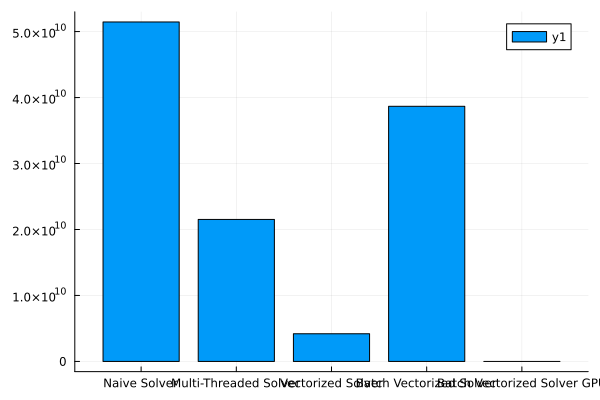

In [99]:
bar(["Naive Solver","Multi-Threaded Solver","Vectorized Solver","Batch Vectorized Solver","Batch Vectorized Solver GPU"], [mean(t_i.times),mean(t_m_i.times),mean(t_v.times),mean(t_b_v.times),t_b_v_GPU])

## Visualize And Demonstrate All Solvers Are Working In Producing The Same Solutions

In [50]:
function draw_mechanism(C,x,fixed_nodes)
    plot(x[:,1], x[:,2], seriestype=:scatter, color="Grey",aspect_ratio = :equal,legend = false, axis= false, grid=false, markersize=5)
    plot!(x[fixed_nodes,1], x[fixed_nodes,2], seriestype=:scatter, color="Black",aspect_ratio = :equal,legend = false, axis= false, grid=false, markersize=5)
    
    for i in 1:size(C)[1]
        for j in findall(x->x>0,C[i,:])
            plot!([x[i,1],x[j,1]],[x[i,2],x[j,2]], color="Black",aspect_ratio = :equal,legend = false, axis= false, grid=false, linewidth=2)
        end
    end
    return plot!(dpi=150)
end

function overlay_solution(sol)
    for i in 1:size(sol)[2]
        plot!(sol[:,i,1],sol[:,i,2],color="#0074bc", linestyle=:solid, linewidth=1.5)
    end
    return plot!()
end

overlay_solution (generic function with 1 method)

In [16]:
# Pick One mechanisms for visualization
i= 551

C = C_list[i];
fixed_nodes = fn_list[i];
x0 = x0s_list[i];
motor = [1,2];

### Iterative Solver

In [17]:
sol = iterative_solver(C, motor, x0, fixed_nodes,thetas);

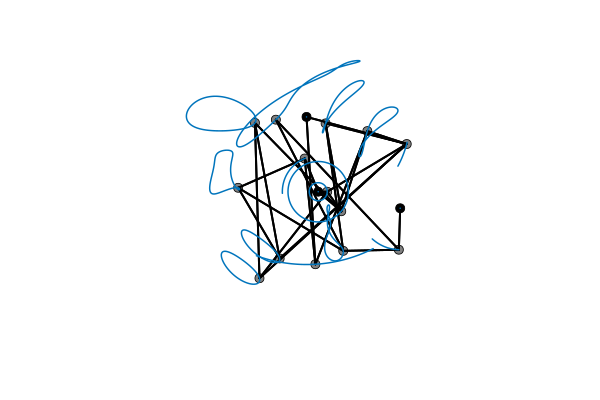

In [18]:
draw_mechanism(C,x0,fixed_nodes)
overlay_solution(sol)

In [19]:
anim = @animate for i ∈ 1:200
    draw_mechanism(C,sol[i,:,:],fixed_nodes)
    overlay_solution(sol[1:i,:,:])
end
gif(anim, "temp_file_anim.gif", fps = 30)

LoadError: failed process: Process(`[4m/home/johnson/.julia/artifacts/b409c0eafb4254a980f9e730f6fbe56867890f6a/bin/ffmpeg[24m [4m-v[24m [4m16[24m [4m-framerate[24m [4m30[24m [4m-i[24m [4m/tmp/jl_sIDsSE/%06d.png[24m [4m-i[24m [4m/tmp/jl_sIDsSE/palette.bmp[24m [4m-lavfi[24m [4mpaletteuse=dither=sierra2_4a[24m [4m-loop[24m [4m0[24m [4m-y[24m [4m'/home/johnson/18337 Project/temp_file_anim.gif'[24m`, ProcessExited(255)) [255]


### Vectorized Solver

In [51]:
sol = vectorized_solution(C, motor, x0, fixed_nodes,thetas);

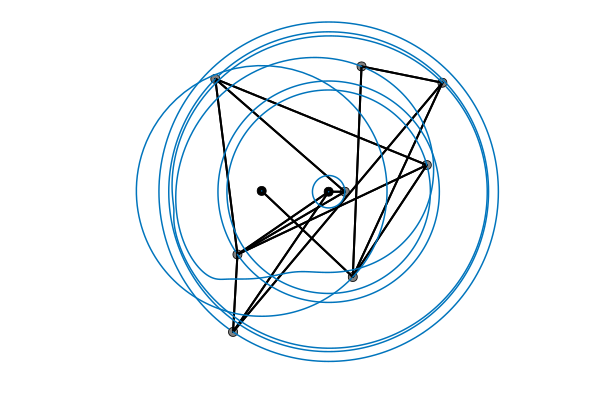

In [52]:
draw_mechanism(C,x0,fixed_nodes)
overlay_solution(sol)

## Gradient-Based Optimization Experiments

First modify the vectorized solver to also return distance to locking

In [22]:
function vectorized_solution_opt(C, motor, x0, fixed_nodes, thetas = LinRange(0,2*pi,201)[1:200])
    p,o,f = find_path(C,motor,fixed_nodes)
    
    if f
        G = pairwise(Euclidean(),x0')
    
    
        x = repeat(reshape(x0,size(x0)[1],1,2),1, size(thetas)[1],1) * 0

        x[fixed_nodes,:,:] = repeat(reshape(x0[fixed_nodes,:], size(fixed_nodes)[1],1,2), 1, size(thetas)[1], 1)

        x[motor[2],:,:] = x[motor[1],:,:] + G[motor[1],motor[2]] * [cos.(thetas) sin.(thetas)]

        flag = true
        
        DL = []

        for step in p
            i = step[2]
            j = step[3]
            k = step[1]
            
            l_ij = norm.(eachcol((x[j,:,:]-x[i,:,:])'))

            cosphi = (l_ij .^ 2 .+ G[i,k]^2 .- G[j,k]^2)./(2 * l_ij * G[i,k])
            
            DL = [DL;copy(cosphi)]
            
            singularities = findall(x-> x>1.0 || x<-1.0, cosphi)

            cosphi[singularities] .= 0.0
            
            s = sign((x0[i,2]-x0[k,2])*(x0[i,1]-x0[j,1]) - (x0[i,2]-x0[j,2])*(x0[i,1]-x0[k,1]))

            phi = s * acos.(cosphi)

            R = reshape([[cos.(phi) sin.(phi)] [-sin.(phi) cos.(phi)]],size(thetas)[1],2,2)

            scaled_ij = (x[j,:,:]-x[i,:,:])./l_ij * G[i,k]

            x[k,:,:] = reshape(permutedims(permutedims(R,[2,3,1]) ⊠ 
                    permutedims(reshape(scaled_ij,size(thetas)[1],2,1),[2,3,1]),[3,1,2]),size(thetas)[1],2) + x[i,:,:]
            x[k,singularities,:] .= NaN
        end

        return permutedims(x,[2,1,3]), 1 .-DL.^2
    else
        return zeros(size(x0)[1], size(thetas)[1],2).-1
    end
    
end

vectorized_solution_opt (generic function with 2 methods)

In [23]:
function normalize_curve(curve)
    c = copy(curve)
    c .-= minimum(c,dims=1)
    sc = maximum(c[:,1])
    c /= sc
    c .-= maximum(c,dims=1)/2
    
    return c
end

normalize_curve (generic function with 1 method)

In [24]:
function chamfer_distance(S1,S2)
    distances = pairwise(Euclidean(),S1',S2')
    D21 = mean(minimum(distances,dims=1))
    D12 = mean(minimum(distances',dims=1))
    
    return mean(norm.(eachcol(S1'-S2')))
end

chamfer_distance (generic function with 1 method)

In [60]:
function get_grads(C,x0,fixed_nodes,motor,target_curve)
    CD = chamfer_distance(normalize_curve(vectorized_solution(C, motor, x0, fixed_nodes,thetas)[:,end,:]),target_curve)
    if !isnan(CD)
        del_CD = ForwardDiff.gradient(x -> chamfer_distance(normalize_curve(vectorized_solution(C, motor, reshape(x,size(C)[1],2), fixed_nodes,thetas)[:,end,:]),target_curve),reshape(x0,size(C)[1]*2));
        del_DL = ForwardDiff.gradient(x -> mean(log.(vectorized_solution_opt(C, motor, reshape(x,size(C)[1],2), fixed_nodes,thetas)[2]/0.001).^2),reshape(x0,size(C)[1]*2));

        lambda = dot(del_CD,del_DL)/norm(del_DL)^2

        return reshape(del_CD - lambda * del_DL,size(x0)[1],2), CD
    else
        return x0*0,CD
    end
end

function get_grads_naive(C,x0,fixed_nodes,motor,target_curve)
    CD = chamfer_distance(normalize_curve(vectorized_solution(C, motor, x0, fixed_nodes,thetas)[:,end,:]),target_curve)
    if !isnan(CD)
        del_CD = ForwardDiff.gradient(x -> chamfer_distance(normalize_curve(vectorized_solution(C, motor, reshape(x,size(C)[1],2), fixed_nodes,thetas)[:,end,:]),target_curve),reshape(x0,size(C)[1]*2));
        del_DL = ForwardDiff.gradient(x -> mean(log.(vectorized_solution_opt(C, motor, reshape(x,size(C)[1],2), fixed_nodes,thetas)[2]/0.001).^2),reshape(x0,size(C)[1]*2));

        lambda = 0.05

        return reshape(del_CD + lambda * del_DL,size(x0)[1],2), CD
    else
        return x0*0,CD
    end
end

get_grads_naive (generic function with 1 method)

## Case Study Of Gradient-Based Optimization For 5 Examples

First specify the mechanisms to be optimized

In [26]:
ind = [256,4534,765,4321,6412];

Now load the target paths we hope to match

In [27]:
targets = load_object("Opt_targets");

Now visualize the target and output

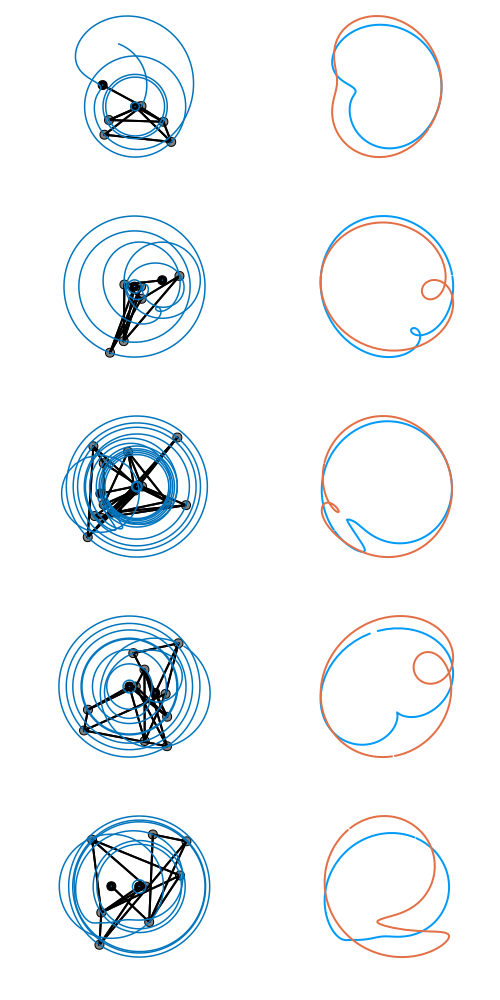

In [64]:
plots = []

for j in 1:5
    i = ind[j]
    C = C_list[i];
    fixed_nodes = fn_list[i];
    x0 = x0s_list[i];
    motor = [1,2];
    
    sol = vectorized_solution(C, motor, x0, fixed_nodes,thetas);
    
    draw_mechanism(C, x0, fixed_nodes)
    pl = overlay_solution(sol)
    push!(plots,pl)
    
    og_n_c = normalize_curve(sol[:,end,:]);
    target_n_c = targets[j]
    plot(og_n_c[:,1],og_n_c[:,2],aspect_ratio = :equal, axis= false, grid=false, linewidth=2, label="Current Output",legend=true)
    pl = plot!(target_n_c[:,1],target_n_c[:,2],aspect_ratio = :equal, axis= false, grid=false, linewidth=2, label="Target Path",legend=true)
    push!(plots,pl)
    pl2 = draw_mechanism(C, x0, fixed_nodes)
end

plot(plots[1],plots[2],plots[3],plots[4],plots[5],plots[6],plots[7],plots[8],plots[9],plots[10],layout=(5,2), legend=false)
plot!(size=(500,1000))

Now run optimization by orthogonolization approach for each case and visualize the results.

In [54]:
optimized_x0s = []
best_cds = []
for j in 1:5
    println("Optimzing case study ", j)
    i = ind[j]
    C = C_list[i];
    fixed_nodes = fn_list[i];
    x0 = x0s_list[i];
    motor = [1,2];
    target_n_c = targets[j];
    alpha = 1e-4;
    
    x0_new = copy(x0)
    x0_old = copy(x0)
    fail_count = 0
    for i in 1:10000
        g,cd = get_grads(C,x0_new,fixed_nodes,motor,target_n_c)
        if i%1000 == 0
            println(cd)
        end
        if isnan(cd)
            fail_count += 1
            alpha *= 0.5
            x0_new = x0_old
            if fail_count >= 50
                break
            end
        end
        x0_old = copy(x0_new)
        x0_new -= g*alpha
    end
    g,cd = get_grads(C,x0_old,fixed_nodes,motor,target_n_c)
    push!(optimized_x0s,x0_old)
    push!(best_cds,cd)
end

Optimzing case study 1
0.5294083657674574
0.4964430584358139
0.49611406038381894
0.4958844963420915
0.4957487845678713
0.4955246029173895
0.49536919250369993
0.49522181835833046
0.4950129686192229
0.4948003577809871
Optimzing case study 2
0.0440366548301652
0.0170936580458221
0.009723536430385983
0.005388562112791767
0.004978808204400043
0.004819742481621645
0.004747121699621981
0.0048020206479734
0.0051423794764312945
0.004852706731481688
Optimzing case study 3
0.04294771994796712
0.02247178423315149
0.017611280333808547
0.014484000931549564
0.012078189976499567
0.01014994956696983
0.008653580888990955
0.007583597004605866
0.006875349994006923
0.006454634902925895
Optimzing case study 4
0.35622135532421395
0.355566632908425
0.3549605091416307
0.3543679954422252
0.35377906000191944
0.35320386988465896
0.35103305315839284
0.3510037507844257
0.3509745908968837
0.35094556744039324
Optimzing case study 5
0.18371778201061112
0.18164899859691414
0.1796048394832917
0.17754353308022464
0.17547

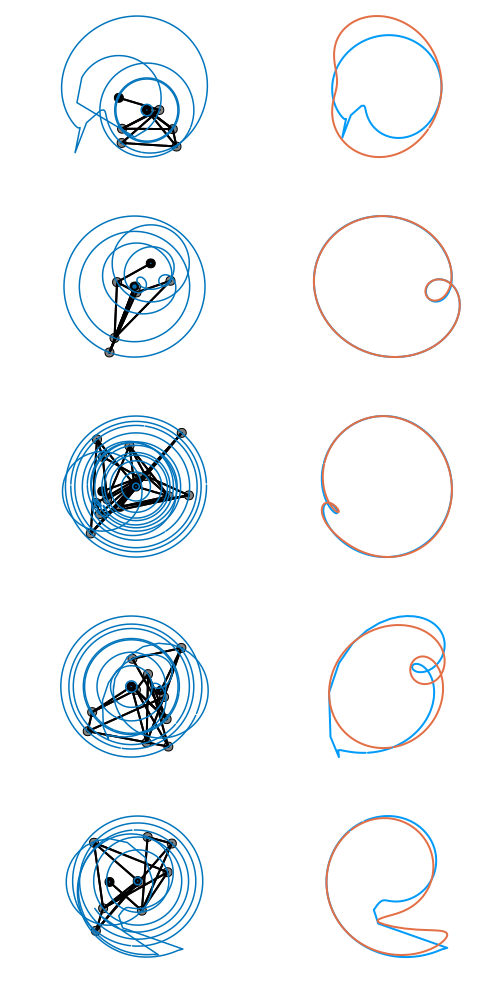

In [55]:
plots = []

for j in 1:5
    i = ind[j]
    C = C_list[i];
    fixed_nodes = fn_list[i];
    x0 = optimized_x0s[j];
    motor = [1,2];
    
    sol = vectorized_solution(C, motor, x0, fixed_nodes,thetas);
    
    draw_mechanism(C, x0, fixed_nodes)
    pl = overlay_solution(sol)
    push!(plots,pl)
    
    og_n_c = normalize_curve(sol[:,end,:]);
    target_n_c = targets[j]
    plot(og_n_c[:,1],og_n_c[:,2],aspect_ratio = :equal, axis= false, grid=false, linewidth=2, label="Current Output",legend=true)
    pl = plot!(target_n_c[:,1],target_n_c[:,2],aspect_ratio = :equal, axis= false, grid=false, linewidth=2, label="Target Path",legend=true)
    push!(plots,pl)
    pl2 = draw_mechanism(C, x0, fixed_nodes)
end

plot(plots[1],plots[2],plots[3],plots[4],plots[5],plots[6],plots[7],plots[8],plots[9],plots[10],layout=(5,2), legend=false)
plot!(size=(500,1000))

Now do the same with the naive approach

In [61]:
optimized_x0s = []
best_cds = []
for j in 1:5
    println("Optimzing case study ", j)
    i = ind[j]
    C = C_list[i];
    fixed_nodes = fn_list[i];
    x0 = x0s_list[i];
    motor = [1,2];
    target_n_c = targets[j];
    alpha = 1e-4;
    
    x0_new = copy(x0)
    x0_old = copy(x0)
    fail_count = 0
    for i in 1:10000
        g,cd = get_grads_naive(C,x0_new,fixed_nodes,motor,target_n_c)
        if i%1000 == 0
            println(cd)
        end
        if isnan(cd)
            fail_count += 1
            alpha *= 0.5
            x0_new = x0_old
            if fail_count >= 50
                break
            end
        end
        x0_old = copy(x0_new)
        x0_new -= g*alpha
    end
    g,cd = get_grads(C,x0_old,fixed_nodes,motor,target_n_c)
    push!(optimized_x0s,x0_old)
    push!(best_cds,cd)
end

Optimzing case study 1
0.6499886608458878
0.6483062936316631
0.646368525628374
0.6443581298871282
0.642190792748083
0.6398832015449067
0.63748008554883
0.6349413801397092
0.6327023923099105
0.6307112056522172
Optimzing case study 2
0.4124078850506392
0.4077328908290923
0.40305366583415186
0.39794816101024316
0.3926329566138756
0.3877239511076647
0.38351512976840474
0.37939177294210585
0.3750321348002634
0.3703415876729716
Optimzing case study 3
0.03776027136889713
0.030594367872518947
0.032733497865591196
0.03536171435393658
0.03377918600775133
0.028329211337179958
0.02664363287299581
0.019777770526041523
0.021559026686539827
0.02152682347217259
Optimzing case study 4
0.3211274527930195
0.3198578996234343
0.3147290974317026
0.31252714690898
0.3106448177880716
0.3090420012348314
0.30785977150497773
0.3070086263448525
0.3027656443137588
0.3001457594015362
Optimzing case study 5
0.07114559286141997
0.06353026273352526
0.0741187037117933
0.0766644647803959
0.06374073575957437
0.08266010692

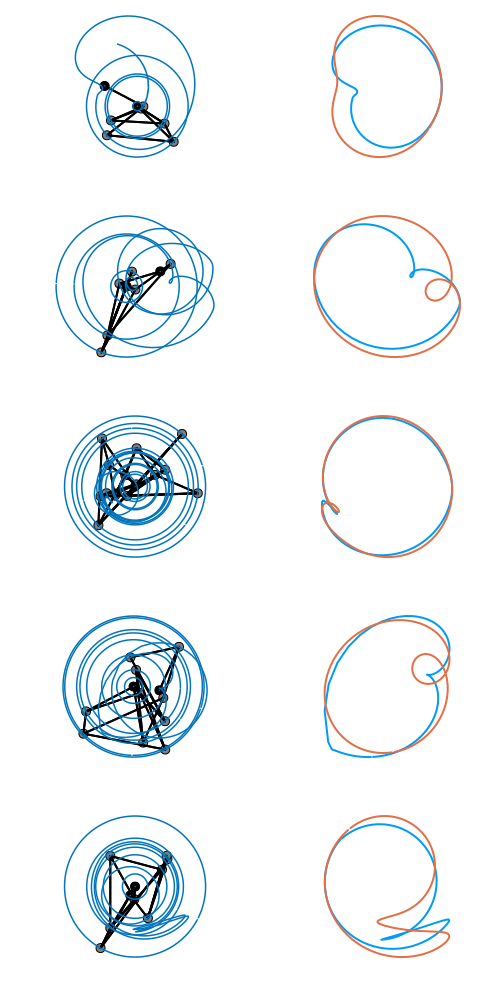

In [62]:
plots = []

for j in 1:5
    i = ind[j]
    C = C_list[i];
    fixed_nodes = fn_list[i];
    x0 = optimized_x0s[j];
    motor = [1,2];
    
    sol = vectorized_solution(C, motor, x0, fixed_nodes,thetas);
    
    draw_mechanism(C, x0, fixed_nodes)
    pl = overlay_solution(sol)
    push!(plots,pl)
    
    og_n_c = normalize_curve(sol[:,end,:]);
    target_n_c = targets[j]
    plot(og_n_c[:,1],og_n_c[:,2],aspect_ratio = :equal, axis= false, grid=false, linewidth=2, label="Current Output",legend=true)
    pl = plot!(target_n_c[:,1],target_n_c[:,2],aspect_ratio = :equal, axis= false, grid=false, linewidth=2, label="Target Path",legend=true)
    push!(plots,pl)
    pl2 = draw_mechanism(C, x0, fixed_nodes)
end

plot(plots[1],plots[2],plots[3],plots[4],plots[5],plots[6],plots[7],plots[8],plots[9],plots[10],layout=(5,2), legend=false)
plot!(size=(500,1000))